## Analyze the learned reward function

In [1]:
env = "HalfCheetah-v5"
algo = "ppo"
seed = 6389
reward_seed = 1789
num_samples = 500

In [2]:
import pickle as pkl
from sklearn.cluster import MiniBatchKMeans
import numpy as np
from rlhf.networks import LightningNetwork

with open(f"samples/ppo_{env}_{seed}.pkl", "rb") as file:
    data = pkl.load(file)

all_in = []
all_rews = []
for idx, seg in enumerate(data["segments"]):
    all_in.extend([(s[0].squeeze(),s[1]) for s in seg])
    all_rews.extend([s[2] for s in seg])
all_rews = np.array(all_rews)

In [3]:
import random

indices = random.sample(range(len(all_in)), num_samples)

# Sample from both lists using the same indices
input_data = [all_in[i] for i in indices]
rews = all_rews[indices]

In [4]:
import os

#rew_fn_types = ["evaluative", "comparative", "demonstrative", "corrective", "descriptive", "descriptive_preference", "cluster_description"]
rew_fn_types = ["corrective"]
reward_functions = []

base_dir = "reward_models"
rew_functions = []
for type in rew_fn_types:
    rew_functions.append(os.path.join(base_dir, f"{algo}_{env}_{reward_seed}_{type}_{reward_seed}.ckpt"))

In [5]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.stats import pearsonr
import torch
 
def pairwise_correlation_heatmap(rewards, names=None):    
    # Compute correlation matrix
    n_functions = rewards.shape[0]
    corr_matrix = np.zeros((n_functions, n_functions))
    for i in range(n_functions):
        for j in range(n_functions):
            corr, _ = pearsonr(rewards[i], rewards[j])
            corr_matrix[i, j] = np.mean(corr)
    
    # Create heatmap
    plt.figure(figsize=(12, 10))
    sns.set(font_scale=1.2)
    heatmap = sns.heatmap(corr_matrix, annot=True, cmap='coolwarm', vmin=-1, vmax=1, center=0,
                          square=True, linewidths=.5, cbar_kws={"shrink": .5})
    
    # Set labels
    if names is None:
        names = [f'Reward {i+1}' for i in range(n_functions)]
    plt.xticks(np.arange(n_functions) + 0.5, names, rotation=45, ha='right')
    plt.yticks(np.arange(n_functions) + 0.5, names, rotation=0)
    
    plt.title('Pairwise Correlations of Reward Functions')
    plt.tight_layout()
    plt.show()

In [6]:
import torch

device = "cpu" if not torch.cuda.is_available() else "cuda:0"

def reward_fn(reward_model_path):
    return lambda input: LightningNetwork.load_from_checkpoint(
                reward_model_path,
                map_location=device
            )(torch.as_tensor(np.array([input[0]] * 4), device=device, dtype=torch.float).unsqueeze((1)),torch.as_tensor(np.array([input[1]] * 4), device=device, dtype=torch.float).unsqueeze(1))

n_functions = len(reward_functions)

# Compute rewards for all functions
pred_rewards = []
pred_std = []
for i, path in enumerate(rew_functions):
    func = reward_fn(path)
    with torch.no_grad():
        preds = torch.vstack([func(x).squeeze() for x in input_data])
        pred_rewards.append(torch.mean(preds, axis=1).cpu().numpy())
        pred_std.append(torch.mean(preds, axis=1).cpu().numpy())
        print(f"Finished {i+1}/{len(rew_functions)} rew. function")

Finished 1/1 rew. function


In [7]:
in_names = ["Ground Truth"] + rew_fn_types

pred_rewards = [rews] + [pr.squeeze() for pr in pred_rewards]

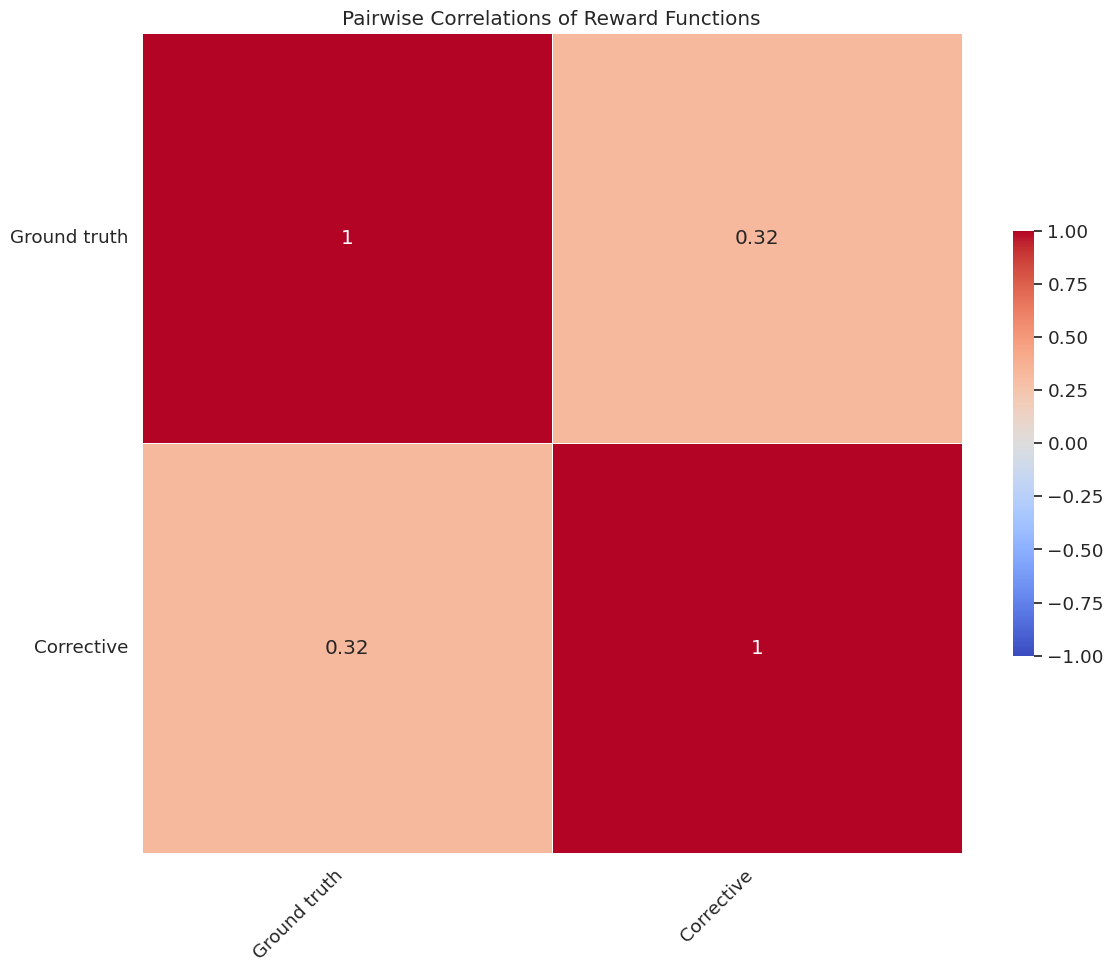

In [8]:
pairwise_correlation_heatmap(np.array(pred_rewards).squeeze(), [rt.capitalize() for rt in in_names])

### Pairwise Correlations

<_io.BufferedReader name='correlation_data/corr_Humanoid-v5_sac_noise_0.0_912391.pkl'>
<_io.BufferedReader name='correlation_data/corr_Humanoid-v5_sac_noise_0.0_1687123.pkl'>
<_io.BufferedReader name='correlation_data/corr_Humanoid-v5_sac_noise_0.0_1789.pkl'>
<_io.BufferedReader name='correlation_data/corr_Humanoid-v5_sac_noise_0.0_330.pkl'>
<_io.BufferedReader name='correlation_data/corr_Humanoid-v5_sac_noise_0.0_12.pkl'>


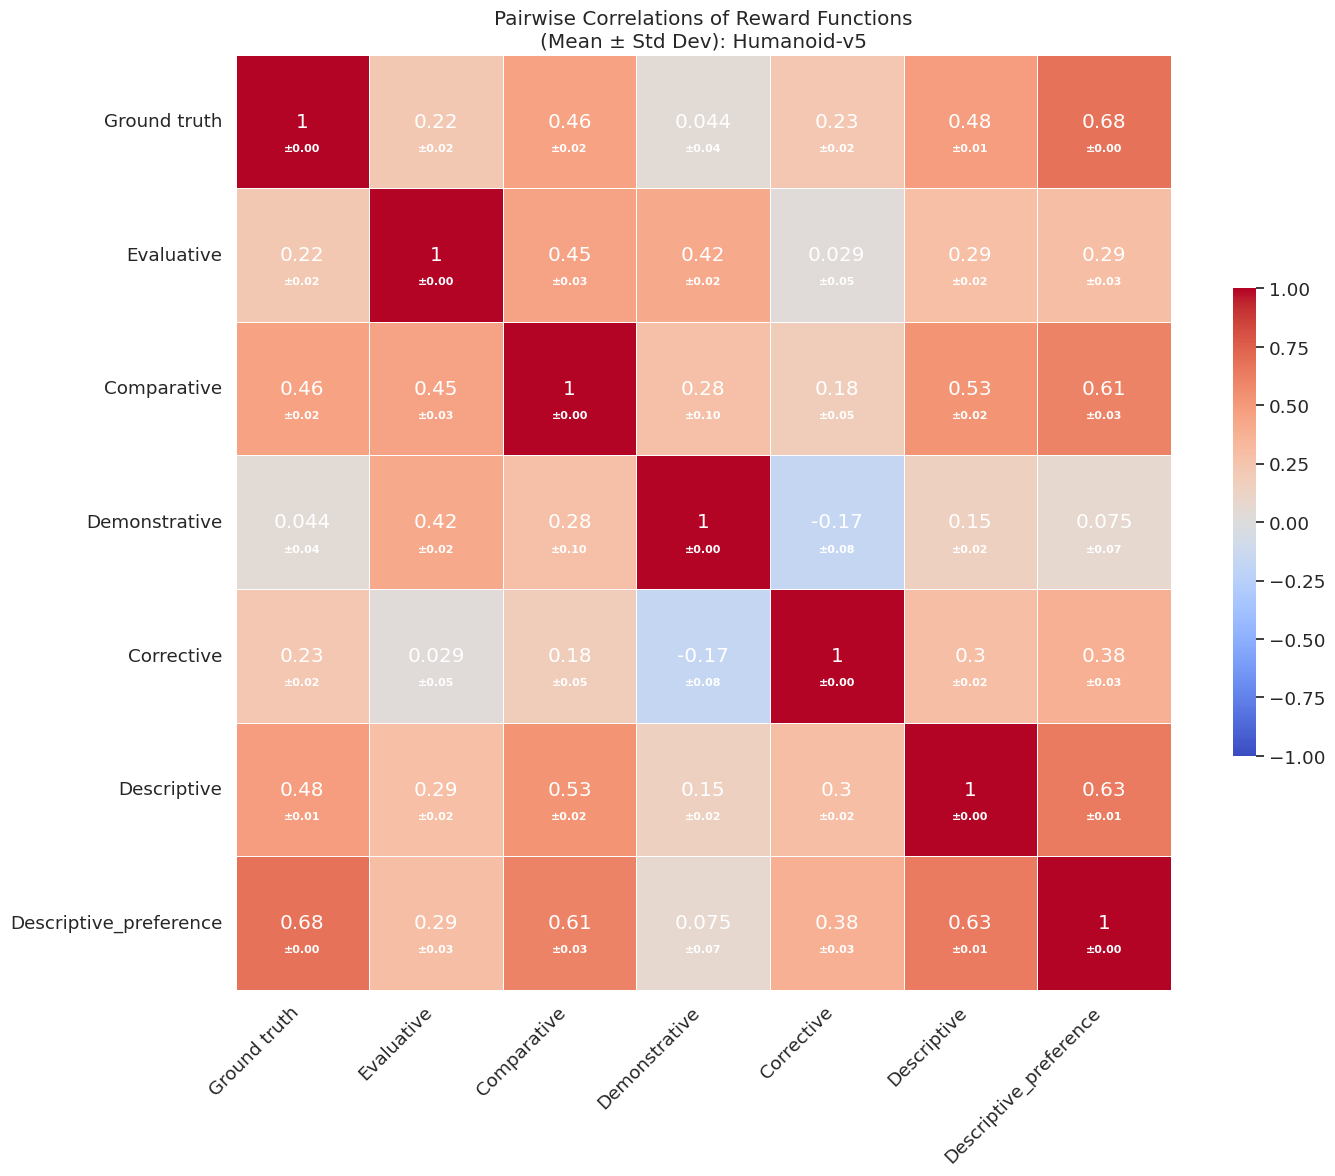

In [18]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.stats import pearsonr
import torch
import pickle
import os

def pairwise_correlation_heatmap(rewards_list, names=None, noise=0.0, env="HalfCheetah-v5"):
    # Ensure rewards_list is a list of numpy arrays
    rewards_list = [np.array(rewards).squeeze() for rewards in rewards_list]
    
    n_functions = rewards_list[0].shape[0]
    n_samples = len(rewards_list)
    
    # Initialize matrices for mean correlations and standard deviations
    mean_corr_matrix = np.zeros((n_functions, n_functions))
    std_corr_matrix = np.zeros((n_functions, n_functions))
    
    # Compute correlations for each sample
    for i in range(n_functions):
        for j in range(n_functions):
            correlations = []
            for rewards in rewards_list:
                corr, _ = pearsonr(rewards[i], rewards[j])
                correlations.append(corr)
            
            mean_corr_matrix[i, j] = np.mean(correlations)
            std_corr_matrix[i, j] = np.std(correlations)
    
    # Create heatmap
    plt.figure(figsize=(15, 12))
    sns.set(font_scale=1.2)
    
    # Plot mean correlations
    heatmap = sns.heatmap(mean_corr_matrix, annot=True, cmap='coolwarm', vmin=-1, vmax=1, center=0,
                          square=True, linewidths=.5, cbar_kws={"shrink": .5}, 
                          annot_kws={"color": "white"})
    
    # Add standard deviations as text
    for i in range(n_functions):
        for j in range(n_functions):
            text = heatmap.text(j + 0.5, i + 0.7, f'±{std_corr_matrix[i, j]:.2f}',
                                ha='center', va='center', color='white', fontweight='bold')
            text.set_fontsize(8)
    
    # Set labels
    if names is None:
        names = [f'Reward {i+1}' for i in range(n_functions)]
    plt.xticks(np.arange(n_functions) + 0.5, names, rotation=45, ha='right')
    plt.yticks(np.arange(n_functions) + 0.5, names, rotation=0)
    
    plt.title(f'Pairwise Correlations of Reward Functions\n(Mean ± Std Dev): {env}')
    plt.tight_layout()

    plt.savefig(f"corr_plot_{env}_noise_{noise}.png")

# Example usage
# pred_rewards_list = [np.array(...), np.array(...), ...]  # List of multiple pred_rewards arrays
# in_names = ['reward1', 'reward2', ...]
# pairwise_correlation_heatmap(pred_rewards_list, [name.capitalize() for name in in_names])

env = "Humanoid-v5"
algo = "sac"
noise = 0.0

all_pred_rewards = []
for seed in [912391, 1687123, 1789, 330, 12]:
    with open(os.path.join("correlation_data", f"corr_{env}_{algo}_noise_{noise}_{seed}.pkl"), "rb") as load_file:
        print(load_file)
        load_rewards = pickle.load(load_file)
        pred_rewards = np.array(load_rewards)
    all_pred_rewards.append(pred_rewards)

rew_fn_types = ["evaluative", "comparative", "demonstrative", "corrective", "descriptive", "descriptive_preference"]
in_names = ["Ground Truth"] + rew_fn_types

pairwise_correlation_heatmap(all_pred_rewards, [name.capitalize() for name in in_names], noise=noise, env=env)

HalfCheetah-v5
Walker2d-v5
Swimmer-v5
Ant-v5
Hopper-v5
Humanoid-v5


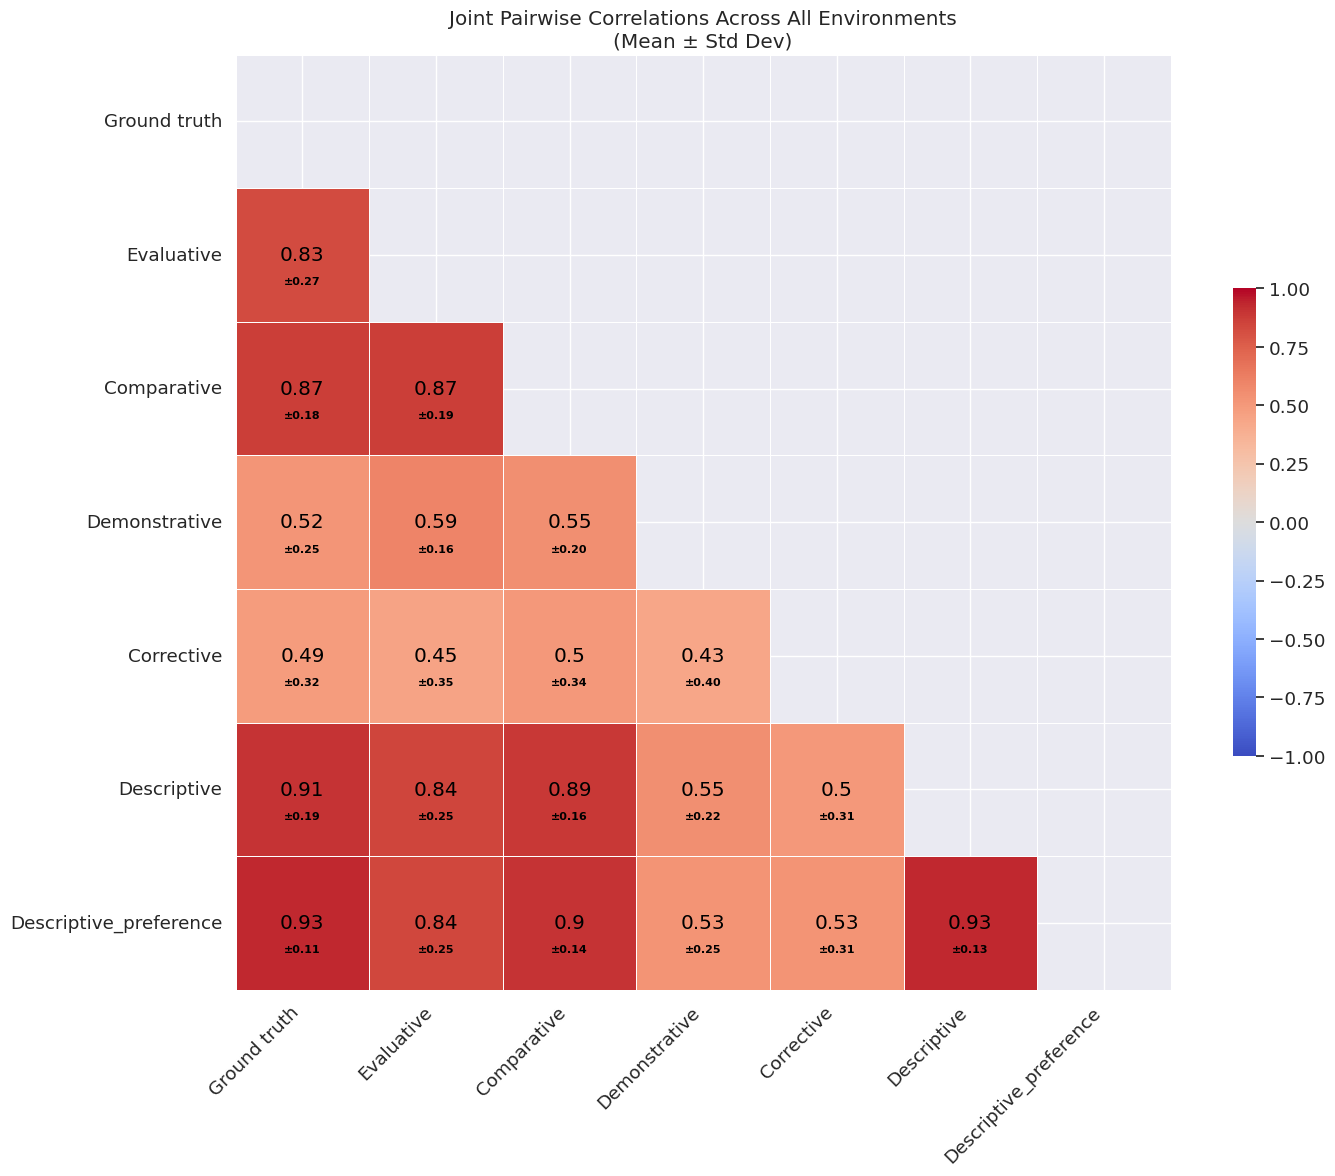

In [14]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.stats import pearsonr
import torch
import pickle
import os

def joint_correlation_heatmap(all_env_rewards_dict, names=None, noise=0.0):
    """
    Generate a joint correlation heatmap across all environments.
    
    Args:
        all_env_rewards_dict: Dictionary mapping environment names to lists of reward arrays
        names: List of reward function names
        noise: Noise level for filename
    """
    # Get dimensions from first environment's first sample
    first_env = list(all_env_rewards_dict.keys())[0]
    n_functions = all_env_rewards_dict[first_env][0].shape[0]
    
    # Initialize arrays to store all correlations
    all_correlations = []
    
    # Compute correlations for each environment and sample
    for env, rewards_list in all_env_rewards_dict.items():
        # Ensure rewards are numpy arrays
        rewards_list = [np.array(rewards).squeeze() for rewards in rewards_list]
        
        # Compute correlations for each sample in this environment
        for rewards in rewards_list:
            env_corr_matrix = np.zeros((n_functions, n_functions))
            for i in range(n_functions):
                for j in range(n_functions):
                    corr, _ = pearsonr(rewards[i], rewards[j])
                    env_corr_matrix[i, j] = corr
            all_correlations.append(env_corr_matrix)
    
    # Convert to numpy array for easier computation
    all_correlations = np.array(all_correlations)
    
    # Compute mean and std across all environments and samples
    mean_corr_matrix = np.mean(all_correlations, axis=0)
    std_corr_matrix = np.std(all_correlations, axis=0)
    
    # Create mask for upper triangle and diagonal
    mask = np.triu(np.ones_like(mean_corr_matrix, dtype=bool))
    
    # Create heatmap
    plt.figure(figsize=(15, 12))
    sns.set(font_scale=1.2)
    
    # Plot mean correlations with mask
    heatmap = sns.heatmap(mean_corr_matrix, 
                         mask=mask,
                         annot=True, 
                         cmap='coolwarm', 
                         vmin=-1, 
                         vmax=1, 
                         center=0,
                         square=True, 
                         linewidths=.5, 
                         cbar_kws={"shrink": .5}, 
                         annot_kws={"color": "black"})
    
    # Add standard deviations as text (only in lower triangle)
    for i in range(n_functions):
        for j in range(n_functions):
            if i > j:  # Only add text in lower triangle
                text = heatmap.text(j + 0.5, i + 0.7, f'±{std_corr_matrix[i, j]:.2f}',
                                  ha='center', va='center', color='black', fontweight='bold')
                text.set_fontsize(8)
    
    # Set labels
    if names is None:
        names = [f'Reward {i+1}' for i in range(n_functions)]
    plt.xticks(np.arange(n_functions) + 0.5, names, rotation=45, ha='right')
    plt.yticks(np.arange(n_functions) + 0.5, names, rotation=0)
    
    plt.title(f'Joint Pairwise Correlations Across All Environments\n(Mean ± Std Dev)')
    plt.tight_layout()
    plt.savefig(f"joint_corr_plot_noise_{noise}.png")

# Example usage
environments = {"ppo": ["HalfCheetah-v5", "Walker2d-v5", "Swimmer-v5"], 
                "sac": ["Ant-v5", "Hopper-v5", "Humanoid-v5"]}  # Add all your environments
algo = ["ppo", "sac"]
noise = 0.0

# Dictionary to store rewards for all environments
all_env_rewards = {}

# Load data for each environment
for i, alg in enumerate(algo):
    for env in environments[alg]:
        print(env)
        env_rewards = []
        for seed in [1687123, 1789, 12]:
            if noise > 0.0:
                file_name = f"corr_{env}_{alg}_noise_{noise}_{seed}.pkl"
            else:
                file_name = f"corr_{env}_{alg}_noise_{noise}_{seed}.pkl"
            with open(os.path.join("../correlation_data", file_name), "rb") as load_file:
                load_rewards = pickle.load(load_file)
                pred_rewards = np.array(load_rewards)
            env_rewards.append(pred_rewards)
        all_env_rewards[env] = env_rewards

# Define reward function types
rew_fn_types = ["evaluative", "comparative", "demonstrative", "corrective", "descriptive", "descriptive_preference"]
in_names = ["Ground Truth"] + rew_fn_types

# Generate joint heatmap
joint_correlation_heatmap(all_env_rewards, [name.capitalize() for name in in_names], noise=noise)

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.stats import pearsonr
import torch
import pickle
import os

def joint_correlation_heatmap(all_env_rewards_dict, names=None, noise=0.0):
    """
    Generate a joint correlation heatmap across all environments with clean white background.
    
    Args:
        all_env_rewards_dict: Dictionary mapping environment names to lists of reward arrays
        names: List of reward function names
        noise: Noise level for filename
    """
    # Get dimensions from first environment's first sample
    first_env = list(all_env_rewards_dict.keys())[0]
    n_functions = all_env_rewards_dict[first_env][0].shape[0]
    
    # Initialize arrays to store all correlations
    all_correlations = []
    
    # Compute correlations for each environment and sample
    for env, rewards_list in all_env_rewards_dict.items():
        rewards_list = [np.array(rewards).squeeze() for rewards in rewards_list]
        for rewards in rewards_list:
            env_corr_matrix = np.zeros((n_functions, n_functions))
            for i in range(n_functions):
                for j in range(n_functions):
                    corr, _ = pearsonr(rewards[i], rewards[j])
                    env_corr_matrix[i, j] = corr
            all_correlations.append(env_corr_matrix)
    
    all_correlations = np.array(all_correlations)
    mean_corr_matrix = np.mean(all_correlations, axis=0)
    std_corr_matrix = np.std(all_correlations, axis=0)
    
    # Create mask for upper triangle and diagonal
    mask = np.triu(np.ones_like(mean_corr_matrix, dtype=bool))
    
    # Set style for clean white background
    plt.style.use('default')
    plt.rcParams['figure.facecolor'] = 'white'
    plt.rcParams['axes.facecolor'] = 'white'
    
    # Create figure and axis
    fig, ax = plt.subplots(figsize=(12, 10))
    
    # Plot heatmap with clean styling
    heatmap = sns.heatmap(mean_corr_matrix,
                         mask=mask,
                         annot=True,
                         cmap='coolwarm',
                         vmin=-1,
                         vmax=1,
                         center=0,
                         square=True,
                         cbar_kws={"shrink": .5},
                         annot_kws={"size": 10},
                         ax=ax)
    
    # Add standard deviations as text
    for i in range(n_functions):
        for j in range(n_functions):
            if i > j:  # Only add text in lower triangle
                text = ax.text(j + 0.5, i + 0.7, f'±{std_corr_matrix[i, j]:.2f}',
                             ha='center', va='center', color='black', fontsize=8, fontweight='bold')
    
    # Clean up the axes
    if names is None:
        names = [f'Reward {i+1}' for i in range(n_functions)]
    
    # Remove all spines
    for spine in ax.spines.values():
        spine.set_visible(False)
    
    # Set labels with clean positioning
    plt.xticks(np.arange(n_functions) + 0.5, names, rotation=45, ha='right')
    plt.yticks(np.arange(n_functions) + 0.5, names, rotation=0)
    
    # Adjust layout to remove empty space
    #plt.title(f'Joint Pairwise Correlations Across All Environments\n(Mean ± Std Dev)', pad=20)
    
    # Tight layout with specific padding
    plt.tight_layout(pad=1.0)
    
    # Save figure with white background
    plt.savefig(f"joint_corr_plot_noise_{noise}.png",
                bbox_inches='tight',
                facecolor='white',
                edgecolor='none',
                pad_inches=0.1,
                dpi=300)
    
    plt.close()

# Example usage
environments = {"ppo": ["HalfCheetah-v5", "Walker2d-v5", "Swimmer-v5"], 
                "sac": ["Ant-v5", "Hopper-v5", "Humanoid-v5"]}
algo = ["ppo", "sac"]
noise = 0.0

# Dictionary to store rewards for all environments
all_env_rewards = {}

# Load data for each environment
for i, alg in enumerate(algo):
    for env in environments[alg]:
        print(env)
        env_rewards = []
        for seed in [1687123, 1789, 12]:
            if noise > 0.0:
                file_name = f"corr_{env}_{alg}_noise_{noise}_{seed}.pkl"
            else:
                file_name = f"corr_{env}_{alg}_noise_{noise}_{seed}.pkl"
            with open(os.path.join("../correlation_data", file_name), "rb") as load_file:
                load_rewards = pickle.load(load_file)
                pred_rewards = np.array(load_rewards)
            env_rewards.append(pred_rewards)
        all_env_rewards[env] = env_rewards

# Define reward function types
rew_fn_types = ["evaluative", "comparative", "demonstrative", "corrective", "descriptive", "descriptive_preference"]
in_names = ["Ground Truth"] + rew_fn_types

# Generate joint heatmap
joint_correlation_heatmap(all_env_rewards, [name.capitalize() for name in in_names], noise=noise)

HalfCheetah-v5
Walker2d-v5
Swimmer-v5
Ant-v5
Hopper-v5
Humanoid-v5


In [14]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.stats import pearsonr
import torch
import pickle
import os

def get_text_color(value):
    """
    Determine whether to use white or black text based on background value.
    """
    return 'white' if abs(value) >= 0.5 else 'black'

def joint_correlation_heatmap(all_env_rewards_dict, names=None, noise=0.0):
    """
    Generate a joint correlation heatmap including diagonal elements.
    """
    # Get dimensions from first environment's first sample
    first_env = list(all_env_rewards_dict.keys())[0]
    n_functions = all_env_rewards_dict[first_env][0].shape[0]
    
    # Initialize arrays to store all correlations
    all_correlations = []
    
    # Compute correlations for each environment and sample
    for env, rewards_list in all_env_rewards_dict.items():
        rewards_list = [np.array(rewards).squeeze() for rewards in rewards_list]
        for rewards in rewards_list:
            env_corr_matrix = np.zeros((n_functions, n_functions))
            for i in range(n_functions):
                for j in range(n_functions):
                    corr, _ = pearsonr(rewards[i], rewards[j])
                    env_corr_matrix[i, j] = corr
            all_correlations.append(env_corr_matrix)
    
    all_correlations = np.array(all_correlations)
    mean_corr_matrix = np.mean(all_correlations, axis=0)
    std_corr_matrix = np.std(all_correlations, axis=0)
    
    # Slice matrices to keep all rows but remove last column
    mean_corr_display = mean_corr_matrix[1:, :-1]
    std_corr_display = std_corr_matrix[1:, :-1]
    
    # Create mask for upper triangle (excluding diagonal)
    mask = np.triu(np.ones_like(mean_corr_display, dtype=bool), k=1)
    
    # Set style for clean white background
    plt.style.use('default')
    plt.rcParams['figure.facecolor'] = 'white'
    plt.rcParams['axes.facecolor'] = 'white'
    
    # Create figure with adjusted size
    fig, ax = plt.subplots(figsize=(14, 12))
    
    # Plot heatmap
    heatmap = sns.heatmap(mean_corr_display,
                         mask=mask,
                         annot=True,
                         fmt='.2f',
                         cmap='coolwarm',
                         vmin=-1,
                         vmax=1,
                         center=0,
                         square=True,
                         cbar_kws={"shrink": .5},
                         annot_kws={"size": 19},
                         ax=ax)
    
    # Add standard deviations as text
    for i in range(len(mean_corr_display)):
        for j in range(len(mean_corr_display[0])):
            if i >= j:  # Modified to include diagonal
                corr_value = mean_corr_display[i, j]
                text_color = get_text_color(corr_value)
                
                text = ax.text(j + 0.5, i + 0.7, f'±{std_corr_display[i, j]:.2f}',
                             ha='center', va='center', 
                             color=text_color,
                             fontsize=18,
                             fontweight='bold')
    
    # Remove spines
    for spine in ax.spines.values():
        spine.set_visible(False)
    
    # Set labels
    if names is not None:
        col_names = names[:-1]  # All except descr. pref.
        row_names = names[1:]   # All except ground truth
        # Abbreviate "Descriptive Preference"
        col_names = [name.replace("Descriptive_preference", "Descr. Pref.") for name in col_names]
        row_names = [name.replace("Descriptive_preference", "Descr. Pref.") for name in row_names]
    
    plt.xticks(np.arange(len(col_names)) + 0.5, col_names, rotation=45, ha='right', fontsize=12)
    plt.yticks(np.arange(len(row_names)) + 0.5, row_names, rotation=0, fontsize=12)
    
    #plt.title(f'Joint Pairwise Correlations Across All Environments\n(Mean ± Std Dev)', 
    #         pad=20, 
    #         fontsize=14)
    
    plt.tight_layout(pad=0.5)
    
    plt.savefig(f"joint_corr_plot_noise_{noise}.png",
                bbox_inches='tight',
                facecolor='white',
                edgecolor='none',
                pad_inches=0.1,
                dpi=300)
    
    plt.close()

# Example usage
environments = {"ppo": ["HalfCheetah-v5", "Walker2d-v5", "Swimmer-v5"], 
                "sac": ["Ant-v5", "Hopper-v5", "Humanoid-v5"]}
algo = ["ppo", "sac"]
noise = 1.5

all_env_rewards = {}

for i, alg in enumerate(algo):
    for env in environments[alg]:
        print(env)
        env_rewards = []
        for seed in [1687123, 1789, 12]:
            file_name = f"corr_{env}_{alg}_noise_{noise}_{seed}.pkl"
            if not os.path.isfile(os.path.join("../correlation_data", file_name)):
                print(os.path.join("../correlation_data", file_name))
                continue
            with open(os.path.join("../correlation_data", file_name), "rb") as load_file:
                load_rewards = pickle.load(load_file)
                pred_rewards = np.array(load_rewards)
            env_rewards.append(pred_rewards)
        all_env_rewards[env] = env_rewards

rew_fn_types = ["evaluative", "comparative", "demonstrative", "corrective", "descriptive", "descriptive_preference"]
in_names = ["Ground Truth"] + rew_fn_types

joint_correlation_heatmap(all_env_rewards, [name.capitalize() for name in in_names], noise=noise)

HalfCheetah-v5
Walker2d-v5
Swimmer-v5
Ant-v5
../correlation_data/corr_Ant-v5_sac_noise_1.5_12.pkl
Hopper-v5
../correlation_data/corr_Hopper-v5_sac_noise_1.5_12.pkl
Humanoid-v5
../correlation_data/corr_Humanoid-v5_sac_noise_1.5_1687123.pkl
../correlation_data/corr_Humanoid-v5_sac_noise_1.5_12.pkl


## Distribution Analysis

In [15]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.manifold import TSNE

def distribution_analysis(rewards1, rewards2, tsne_coordinates):
    
    # Histogram
    plt.figure(figsize=(17, 5))
    plt.subplot(1, 3, 1)

    plt.scatter(rewards1, rewards2, alpha=0.5) #, label='Ground Truth Reward')
    #plt.hist(rewards2, bins=30, alpha=0.5, label='Learned Reward Function')
    plt.xlabel('Reward Value')
    plt.ylabel('Frequency')
    plt.title('Distribution of Rewards')
    plt.legend()

    plt.subplot(1, 3, 2)
    plt.scatter(tsne_coordinates[:, 0], tsne_coordinates[:, 1], c=rewards1, cmap='viridis')
    plt.colorbar(label='Reward Value (Ground Truth)')
    plt.title('t-SNE Visualization of Ground Truth Rewards')
    plt.tight_layout()

    plt.subplot(1, 3, 3)
    plt.scatter(tsne_coordinates[:, 0], tsne_coordinates[:, 1], c=rewards2, cmap='viridis')
    plt.colorbar(label='Reward Value (Function 2)')
    plt.title('t-SNE Visualization of Reward Functions')
    plt.tight_layout()

    #plt.savefig("tsne_plot_rew_predictions_{}".png")

# Example usage

# t-SNE visualization
tsne_input_data = np.array([np.concatenate(d) for d in input_data])
tsne = TSNE(n_components=2, random_state=42)
tsne_coordinates = tsne.fit_transform(tsne_input_data)

for i in range(len(pred_rewards)):
    distribution_analysis(pred_rewards[0], pred_rewards[i], tsne_coordinates)

NameError: name 'input_data' is not defined

## Generate Correlation Line Plot

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.stats import pearsonr
import torch
import pickle
import os
from collections import OrderedDict, defaultdict

#seeds=[1687123, 1789, 12]

def create_correlation_line_plot(env="HalfCheetah-v5", algo="ppo", seeds=[1687123, 1789, 12], 
                               noise_levels=[0.0, 0.25, 0.5, 0.75, 1.5, 3.0]):
    # Define color scale
    color_scale = OrderedDict([
        ('evaluative', '#1f77b4'),     # blue
        ('comparative', '#ff7f0e'),    # orange
        ('demonstrative', '#2ca02c'),  # green
        ('corrective', '#d62728'),     # red
        ('descriptive', '#9467bd'),    # purple
        ('preference', '#8c564b'),     # brown
    ])
    
    # Initialize data structures to store correlations
    correlations = defaultdict(lambda: defaultdict(list))
    
    # Reward function types
    rew_fn_types = ["evaluative", "comparative", "demonstrative", "corrective", "descriptive", "descriptive_preference"]
    
    # Process data for each noise level
    for noise in noise_levels:
        # Collect rewards for all seeds at this noise level
        all_pred_rewards = []
        for seed in seeds:
            print(env, algo, noise, seed)
            if not os.path.isfile(os.path.join("..", "correlation_data", f"corr_{env}_{algo}_noise_{noise}_{seed}.pkl")):
                print("..", "correlation_data", f"corr_{env}_{algo}_noise_{noise}_{seed}.pkl")
                continue
            filepath = os.path.join("..", "correlation_data", f"corr_{env}_{algo}_noise_{noise}_{seed}.pkl")
            with open(filepath, "rb") as load_file:
                load_rewards = pickle.load(load_file)
                pred_rewards = np.array(load_rewards)
                all_pred_rewards.append(pred_rewards)
        
        # Calculate correlations with ground truth for each reward type
        for reward_type_idx, reward_type in enumerate(rew_fn_types, 1):  # Start from 1 to skip ground truth
            for rewards in all_pred_rewards:
                corr, _ = pearsonr(rewards[0], rewards[reward_type_idx])  # rewards[0] is ground truth
                correlations[reward_type][noise].append(corr)
    
    # Create the plot
    plt.figure(figsize=(12, 6))
    
    # Plot line for each reward type
    for reward_type in rew_fn_types:
        display_name = reward_type.replace('descriptive_preference', 'preference').capitalize()
        
        # Calculate mean and std for each noise level
        noise_means = []
        noise_stds = []
        for noise in noise_levels:
            corrs = correlations[reward_type][noise]
            noise_means.append(np.mean(corrs))
            noise_stds.append(np.std(corrs))
        
        # Convert to numpy arrays
        noise_means = np.array(noise_means)
        noise_stds = np.array(noise_stds)
        
        # Plot mean line and std band
        color = color_scale[reward_type.replace('descriptive_preference', 'preference')]
        plt.plot(noise_levels, noise_means, '-o', label=display_name, color=color, linewidth=2, markersize=8)
        plt.fill_between(noise_levels, 
                        noise_means - noise_stds,
                        noise_means + noise_stds,
                        alpha=0.2,
                        color=color)
    
    # Customize plot
    plt.xlabel('Noise Level', fontsize=14)
    plt.ylabel('Correlation with Ground Truth', fontsize=14)
    #plt.title(f'Reward Function Correlations vs. Noise Level\n{env}', fontsize=16)
    plt.grid(True, linestyle='--', alpha=0.7)
    plt.legend(fontsize=14)
    
    # Set axis limits and ticks
    plt.ylim(-0.2, 1.1)
    plt.xlim(-0.05, max(noise_levels) + 0.05)
    
    # Adjust layout to prevent legend cutoff
    plt.tight_layout()
    
    # Save plot
    plt.savefig(f"correlation_lines_{env}_noise.png", bbox_inches='tight', dpi=300)
    plt.close()

# Example usage
envs = ["HalfCheetah-v5", "Walker2d-v5", "Swimmer-v5"]  # Add more environments as needed
for env in envs:
    create_correlation_line_plot(env=env)

# Example usage
envs = ["Ant-v5", "Hopper-v5", "Humanoid-v5"]  # Add more environments as needed
for env in envs:
    create_correlation_line_plot(env=env, algo="sac")

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.stats import pearsonr
import torch
import pickle
import os
from collections import OrderedDict, defaultdict

#seeds=[1687123, 1789, 12]

def create_correlation_line_plot(env="HalfCheetah-v5", algo="ppo", seeds=[1687123, 1789, 12], 
                               noise_levels=[0.0, 0.25, 0.5, 0.75, 1.5, 3.0]):
    # Define color scale
    color_scale = OrderedDict([
        ('evaluative', '#1f77b4'),     # blue
        ('comparative', '#ff7f0e'),    # orange
        ('demonstrative', '#2ca02c'),  # green
        ('corrective', '#d62728'),     # red
        ('descriptive', '#9467bd'),    # purple
        ('preference', '#8c564b'),     # brown
    ])
    
    # Initialize data structures to store correlations
    correlations = defaultdict(lambda: defaultdict(list))
    
    # Reward function types
    rew_fn_types = ["evaluative", "comparative", "demonstrative", "corrective", "descriptive", "descriptive_preference"]
    
    # Process data for each noise level
    for noise in noise_levels:
        # Collect rewards for all seeds at this noise level
        all_pred_rewards = []
        for seed in seeds:
            print(env, algo, noise, seed)
            if not os.path.isfile(os.path.join("..", "correlation_data", f"corr_{env}_{algo}_noise_{noise}_{seed}.pkl")):
                print("..", "correlation_data", f"corr_{env}_{algo}_noise_{noise}_{seed}.pkl")
                continue
            filepath = os.path.join("..", "correlation_data", f"corr_{env}_{algo}_noise_{noise}_{seed}.pkl")
            with open(filepath, "rb") as load_file:
                load_rewards = pickle.load(load_file)
                pred_rewards = np.array(load_rewards)
                all_pred_rewards.append(pred_rewards)
        
        # Calculate correlations with ground truth for each reward type
        for reward_type_idx, reward_type in enumerate(rew_fn_types, 1):  # Start from 1 to skip ground truth
            for rewards in all_pred_rewards:
                corr, _ = pearsonr(rewards[0], rewards[reward_type_idx])  # rewards[0] is ground truth
                correlations[reward_type][noise].append(corr)
    
    # Create the plot
    plt.figure(figsize=(12, 6))
    
    # Plot line for each reward type
    for reward_type in rew_fn_types:
        display_name = reward_type.replace('descriptive_preference', 'preference').capitalize()
        
        # Calculate mean and std for each noise level
        noise_means = []
        noise_stds = []
        for noise in noise_levels:
            corrs = correlations[reward_type][noise]
            noise_means.append(np.mean(corrs))
            noise_stds.append(np.std(corrs))
        
        # Convert to numpy arrays
        noise_means = np.array(noise_means)
        noise_stds = np.array(noise_stds)
        
        # Plot mean line and std band
        color = color_scale[reward_type.replace('descriptive_preference', 'preference')]
        plt.plot(noise_levels, noise_means, '-o', label=display_name, color=color, linewidth=2, markersize=8)
        plt.fill_between(noise_levels, 
                        noise_means - noise_stds,
                        noise_means + noise_stds,
                        alpha=0.2,
                        color=color)
    
    # Customize plot
    plt.xlabel('Noise Level', fontsize=14)
    plt.ylabel('Correlation with Ground Truth', fontsize=14)
    #plt.title(f'Reward Function Correlations vs. Noise Level\n{env}', fontsize=16)
    plt.grid(True, linestyle='--', alpha=0.7)
    plt.legend(fontsize=14)
    
    # Set axis limits and ticks
    plt.ylim(-0.2, 1.1)
    plt.xlim(-0.05, max(noise_levels) + 0.05)
    
    # Adjust layout to prevent legend cutoff
    plt.tight_layout()
    
    # Save plot
    plt.savefig(f"correlation_lines_{env}_noise.png", bbox_inches='tight', dpi=300)
    plt.close()

# Example usage
envs = ["HalfCheetah-v5", "Walker2d-v5", "Swimmer-v5"]  # Add more environments as needed
for env in envs:
    create_correlation_line_plot(env=env)

# Example usage
envs = ["Ant-v5", "Hopper-v5", "Humanoid-v5"]  # Add more environments as needed
for env in envs:
    create_correlation_line_plot(env=env, algo="sac")

In [22]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.stats import pearsonr
import torch
import pickle
import os
from collections import OrderedDict, defaultdict

def create_aggregated_correlation_plot(
    envs=["HalfCheetah-v5", "Walker2d-v5", "Swimmer-v5", "Ant-v5", "Hopper-v5", "Humanoid-v5"],
    algos={"HalfCheetah-v5": "ppo", "Walker2d-v5": "ppo", "Swimmer-v5": "ppo", 
           "Ant-v5": "sac", "Hopper-v5": "sac", "Humanoid-v5": "sac"},
    seeds=[1687123, 1789, 12],
    noise_levels=[0.0, 0.25, 0.5, 0.75, 1.5, 3.0]
):
    # Define color scale
    color_scale = OrderedDict([
        ('evaluative', '#1f77b4'),     # blue
        ('comparative', '#ff7f0e'),    # orange
        ('demonstrative', '#2ca02c'),  # green
        ('corrective', '#d62728'),     # red
        ('descriptive', '#9467bd'),    # purple
        ('preference', '#8c564b'),     # brown
    ])
    
    # Initialize data structures to store correlations
    correlations = defaultdict(lambda: defaultdict(list))
    
    # Reward function types
    rew_fn_types = ["evaluative", "comparative", "demonstrative", "corrective", "descriptive", "descriptive_preference"]
    
    # Process data for each environment and noise level
    for env in envs:
        algo = algos[env]
        for noise in noise_levels:
            # Collect rewards for all seeds at this noise level
            all_pred_rewards = []
            for seed in seeds:
                filepath = os.path.join("..", "correlation_data", f"corr_{env}_{algo}_noise_{noise}_{seed}.pkl")
                if not os.path.isfile(filepath):
                    print(f"Missing file: {filepath}")
                    continue
                    
                with open(filepath, "rb") as load_file:
                    load_rewards = pickle.load(load_file)
                    pred_rewards = np.array(load_rewards)
                    all_pred_rewards.append(pred_rewards)
            
            # Calculate correlations with ground truth for each reward type
            for reward_type_idx, reward_type in enumerate(rew_fn_types, 1):
                for rewards in all_pred_rewards:
                    corr, _ = pearsonr(rewards[0], rewards[reward_type_idx])
                    correlations[reward_type][noise].append(corr)
    
    # Create the plot
    plt.figure(figsize=(12, 6))
    
    # Plot line for each reward type
    for reward_type in rew_fn_types:
        display_name = reward_type.replace('descriptive_preference', 'preference').capitalize()
        
        # Calculate aggregate statistics across all environments
        noise_means = []
        noise_stds = []
        for noise in noise_levels:
            corrs = correlations[reward_type][noise]
            noise_means.append(np.mean(corrs))
            noise_stds.append(np.std(corrs))
        
        # Convert to numpy arrays
        noise_means = np.array(noise_means)
        noise_stds = np.array(noise_stds)
        
        # Plot mean line and std band
        color = color_scale[reward_type.replace('descriptive_preference', 'preference')]
        plt.plot(noise_levels, noise_means, '-o', label=display_name, color=color, linewidth=2, markersize=8)
        plt.fill_between(noise_levels, 
                        noise_means - noise_stds,
                        noise_means + noise_stds,
                        alpha=0.2,
                        color=color)
    
    # Customize plot
    plt.xlabel('Noise Level', fontsize=14)
    plt.ylabel('Correlation with Ground Truth', fontsize=14)
    plt.title('Aggregate Reward Function Correlations vs. Noise Level\nAcross All Environments', fontsize=16)
    plt.grid(True, linestyle='--', alpha=0.7)
    plt.legend(fontsize=12, bbox_to_anchor=(1.05, 1), loc='upper left')
    
    # Set axis limits and ticks
    plt.ylim(-0.2, 1.1)
    plt.xlim(-0.05, max(noise_levels) + 0.05)
    
    # Adjust layout to prevent legend cutoff
    plt.tight_layout()
    
    # Save plot
    plt.savefig("aggregate_correlation_lines.png", bbox_inches='tight', dpi=300)
    plt.close()

# Example usage
create_aggregated_correlation_plot()

Missing file: ../correlation_data/corr_Ant-v5_sac_noise_1.5_12.pkl
Missing file: ../correlation_data/corr_Ant-v5_sac_noise_3.0_12.pkl
Missing file: ../correlation_data/corr_Hopper-v5_sac_noise_1.5_12.pkl
Missing file: ../correlation_data/corr_Hopper-v5_sac_noise_3.0_12.pkl
Missing file: ../correlation_data/corr_Humanoid-v5_sac_noise_1.5_1687123.pkl
Missing file: ../correlation_data/corr_Humanoid-v5_sac_noise_1.5_12.pkl
Missing file: ../correlation_data/corr_Humanoid-v5_sac_noise_3.0_1687123.pkl
Missing file: ../correlation_data/corr_Humanoid-v5_sac_noise_3.0_12.pkl


## N Feedback

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.stats import pearsonr
import torch
import pickle
import os
from collections import OrderedDict, defaultdict

#seeds=[1687123, 1789, 12]

def create_correlation_line_plot(env="HalfCheetah-v5", algo="ppo", seeds=[1687123, 1789, 12], 
                               noise_levels=[0.0, 0.25, 0.5, 0.75, 1.5, 3.0]):
    # Define color scale
    color_scale = OrderedDict([
        ('evaluative', '#1f77b4'),     # blue
        ('comparative', '#ff7f0e'),    # orange
        ('demonstrative', '#2ca02c'),  # green
        ('corrective', '#d62728'),     # red
        ('descriptive', '#9467bd'),    # purple
        ('preference', '#8c564b'),     # brown
    ])
    
    # Initialize data structures to store correlations
    correlations = defaultdict(lambda: defaultdict(list))
    
    # Reward function types
    rew_fn_types = ["evaluative", "comparative", "demonstrative", "corrective", "descriptive", "descriptive_preference"]
    
    # Process data for each noise level
    for noise in noise_levels:
        # Collect rewards for all seeds at this noise level
        all_pred_rewards = []
        for seed in seeds:
            print(env, algo, noise, seed)
            if not os.path.isfile(os.path.join("..", "correlation_data", f"corr_{env}_{algo}_nfeedback_{nfeedback}_{seed}.pkl")):
                print("..", "correlation_data", f"corr_{env}_{algo}_noise_{noise}_{seed}.pkl")
                continue
            filepath = os.path.join("..", "correlation_data", f"corr_{env}_{algo}_noise_{noise}_{seed}.pkl")
            with open(filepath, "rb") as load_file:
                load_rewards = pickle.load(load_file)
                pred_rewards = np.array(load_rewards)
                all_pred_rewards.append(pred_rewards)
        
        # Calculate correlations with ground truth for each reward type
        for reward_type_idx, reward_type in enumerate(rew_fn_types, 1):  # Start from 1 to skip ground truth
            for rewards in all_pred_rewards:
                corr, _ = pearsonr(rewards[0], rewards[reward_type_idx])  # rewards[0] is ground truth
                correlations[reward_type][noise].append(corr)
    
    # Create the plot
    plt.figure(figsize=(12, 6))
    
    # Plot line for each reward type
    for reward_type in rew_fn_types:
        display_name = reward_type.replace('descriptive_preference', 'preference').capitalize()
        
        # Calculate mean and std for each noise level
        noise_means = []
        noise_stds = []
        for noise in noise_levels:
            corrs = correlations[reward_type][noise]
            noise_means.append(np.mean(corrs))
            noise_stds.append(np.std(corrs))
        
        # Convert to numpy arrays
        noise_means = np.array(noise_means)
        noise_stds = np.array(noise_stds)
        
        # Plot mean line and std band
        color = color_scale[reward_type.replace('descriptive_preference', 'preference')]
        plt.plot(noise_levels, noise_means, '-o', label=display_name, color=color, linewidth=2, markersize=8)
        plt.fill_between(noise_levels, 
                        noise_means - noise_stds,
                        noise_means + noise_stds,
                        alpha=0.2,
                        color=color)
    
    # Customize plot
    plt.xlabel('Noise Level', fontsize=14)
    plt.ylabel('Correlation with Ground Truth', fontsize=14)
    #plt.title(f'Reward Function Correlations vs. Noise Level\n{env}', fontsize=16)
    plt.grid(True, linestyle='--', alpha=0.7)
    plt.legend(fontsize=14)
    
    # Set axis limits and ticks
    plt.ylim(-0.2, 1.1)
    plt.xlim(-0.05, max(noise_levels) + 0.05)
    
    # Adjust layout to prevent legend cutoff
    plt.tight_layout()
    
    # Save plot
    plt.savefig(f"correlation_lines_{env}_noise.png", bbox_inches='tight', dpi=300)
    plt.close()

# Example usage
envs = ["HalfCheetah-v5", "Walker2d-v5", "Swimmer-v5"]  # Add more environments as needed
for env in envs:
    create_correlation_line_plot(env=env)

# Example usage
envs = ["Ant-v5", "Hopper-v5", "Humanoid-v5"]  # Add more environments as needed
for env in envs:
    create_correlation_line_plot(env=env, algo="sac")

## Small Multiples

KeyError: 'desc.pref.'

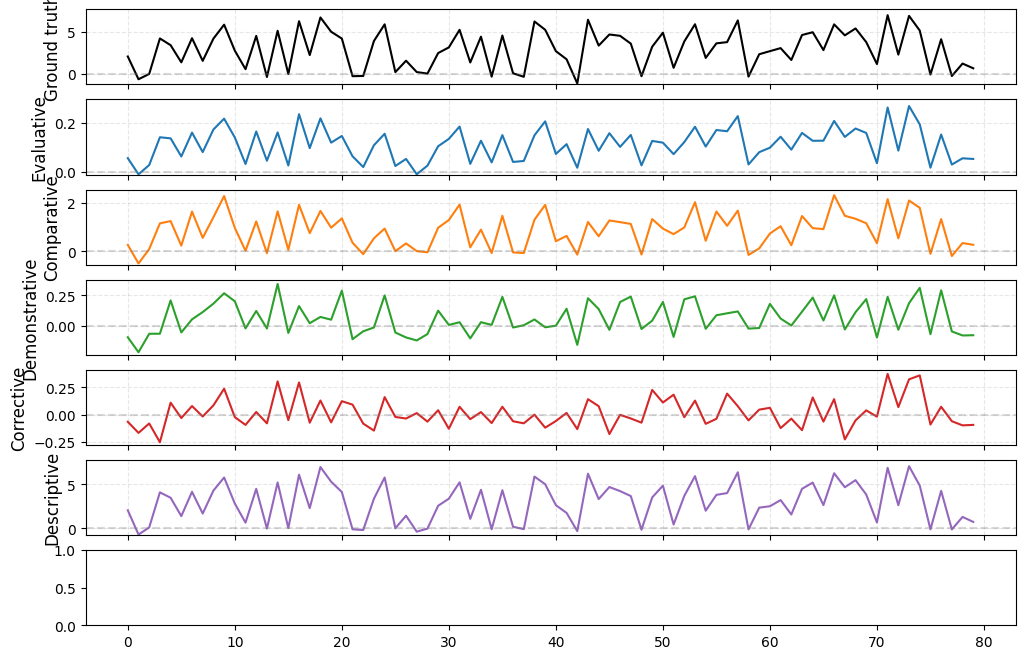

In [11]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import pickle
import os
from collections import OrderedDict

def create_sequence_small_multiples(env="HalfCheetah-v5", algo="ppo", seed=12, noise_level=0.0, sequence_length=80):
    # Define color scale
    color_scale = OrderedDict([
        ('ground_truth', '#000000'),   # black
        ('evaluative', '#1f77b4'),     # blue
        ('comparative', '#ff7f0e'),    # orange
        ('demonstrative', '#2ca02c'),  # green
        ('corrective', '#d62728'),     # red
        ('descriptive', '#9467bd'),    # purple
        ('preference', '#8c564b'),     # brown
    ])
    
    # Load data
    filepath = os.path.join("..", "correlation_data_fixed", f"corr_{env}_{algo}_noise_{noise_level}_{seed}.pkl")
    with open(filepath, "rb") as load_file:
        rewards = pickle.load(load_file)
        pred_rewards = np.array(rewards)
    
    # Reward function types with ground truth
    rew_fn_types = ["ground_truth", "evaluative", "comparative", "demonstrative", 
                    "corrective", "descriptive", "descriptive_preference"]
    
    # Create the small multiples plot
    fig, axes = plt.subplots(len(rew_fn_types), 1, figsize=(12, 8), sharex=True)
    #fig.suptitle(f'Reward Function Predictions Over Time{env}, Noise Level: {noise_level}', 
    #            fontsize=14)
    
    # Plot each reward function type
    for idx, (reward_type, ax) in enumerate(zip(rew_fn_types, axes)):
        display_name = reward_type.replace('descriptive_preference', 'preference')
        display_name = display_name.replace('ground_truth', 'Ground Truth')
        display_name = display_name.capitalize()
        
        # Get sequence data (first 500 steps)
        sequence = pred_rewards[idx][:sequence_length]
        
        # Plot the sequence
        color = color_scale[reward_type.replace('descriptive_preference', 'preference')]
        ax.plot(sequence, color=color, linewidth=1.5)
        
        # Add horizontal line at y=0
        ax.axhline(y=0, color='gray', linestyle='--', alpha=0.3)
        
        # Customize subplot
        ax.set_ylabel(display_name, fontsize=12)
        ax.grid(True, linestyle='--', alpha=0.3)
        
        # Set y-axis limits to be symmetric around 0
        #max_abs_val = max(abs(sequence.min()), abs(sequence.max()))
        min = sequence.min() * 1.1 if sequence.min() < 0 else sequence.min() * 0.9
        ax.set_ylim(min, sequence.max() * 1.1)
        
        # Only show x-axis label on bottom subplot
        if idx == len(rew_fn_types) - 1:
            ax.set_xlabel('Time Steps', fontsize=12)
    
    # Adjust layout
    plt.tight_layout()
    
    # Save plot
    plt.savefig(f"sequence_multiples_{env}_noise_{noise_level}.png", 
                bbox_inches='tight', dpi=300)
    plt.close()

# Example usage for different environments and noise levels
envs = ["HalfCheetah-v5", "Walker2d-v5", "Swimmer-v]
noise_levels = [0.0]

for env in envs:
    for noise in noise_levels:
        create_sequence_small_multiples(env=env, noise_level=noise)

In [10]:
# Example usage for different environments and noise levels
envs = ["Humanoid-v5", "Ant-v5", "Hopper-v5"]
noise_levels = [0.0]

for env in envs:
    for noise in noise_levels:
        create_sequence_small_multiples(env=env, noise_level=noise, algo="sac")